<a href="https://colab.research.google.com/github/mezkymy/global-salaries/blob/main/global-salaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Salaries
source: https://ai-jobs.net/salaries/download/


### Data Description (from source)



> "We collect salary information anonymously from professionals and employers all over the world and make it publicly available for anyone to use, share and play around with.
> Our goal is to have open salary data for everyone. So newbies, experienced pros, hiring managers, recruiters and also startup founders or people wanting to switch careers can make better decisions."


In [1]:
# import main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# for tukey
!pip install bioinfokit
from bioinfokit.analys import stat

In [2]:
# load data
account = 'mezkymy'
repo = 'global-salaries'
branch = 'main'
data_file_name = 'salaries.csv'

url = str(f'https://raw.githubusercontent.com/{account}/{repo}/{branch}/{data_file_name}')

raw_data = pd.read_csv(url)
df = raw_data.copy()
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,EX,FT,Data Science Director,212000,USD,212000,US,0,US,M
1,2023,EX,FT,Data Science Director,190000,USD,190000,US,0,US,M
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M


## Preliminary Data Exploration

In [3]:
# basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8805 entries, 0 to 8804
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           8805 non-null   int64 
 1   experience_level    8805 non-null   object
 2   employment_type     8805 non-null   object
 3   job_title           8805 non-null   object
 4   salary              8805 non-null   int64 
 5   salary_currency     8805 non-null   object
 6   salary_in_usd       8805 non-null   int64 
 7   employee_residence  8805 non-null   object
 8   remote_ratio        8805 non-null   int64 
 9   company_location    8805 non-null   object
 10  company_size        8805 non-null   object
dtypes: int64(4), object(7)
memory usage: 756.8+ KB


In [4]:
# check values distribution on numerical data
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,8805.000000,8.805000e+03,8805.000000,8805.000000
mean,2022.737422,1.747287e+05,149488.265645,38.693924
std,0.542484,4.560690e+05,64222.105058,48.068060
min,2020.000000,1.400000e+04,15000.000000,0.000000
25%,2023.000000,1.055000e+05,105000.000000,0.000000
50%,2023.000000,1.441000e+05,142200.000000,0.000000
75%,2023.000000,1.900000e+05,185900.000000,100.000000
max,2023.000000,3.040000e+07,615201.000000,100.000000


## Remote Ratio

In [5]:
df.remote_ratio.unique()

array([  0, 100,  50])

Based on the data source and also by checking the data directly, we can see that `remote_ratio` only have three unique values: 0, 50, and 100. This data can be treated as categorical rather than numerical. 0 means up to 20% remote work, while 100 means more than 80% remote work. To avoid confusion with this numerical category, this will be renamed to onsite, hybrid, and remote.

In [6]:
cond = [df.remote_ratio < 50, df.remote_ratio > 50]
val = ['onsite', 'remote']

df['remote_cat'] = np.select(cond, val, 'hybrid')
pd.value_counts(df.remote_cat)

onsite    5289
remote    3298
hybrid     218
Name: remote_cat, dtype: int64

## Experience Level, Employment Type, and Company Size

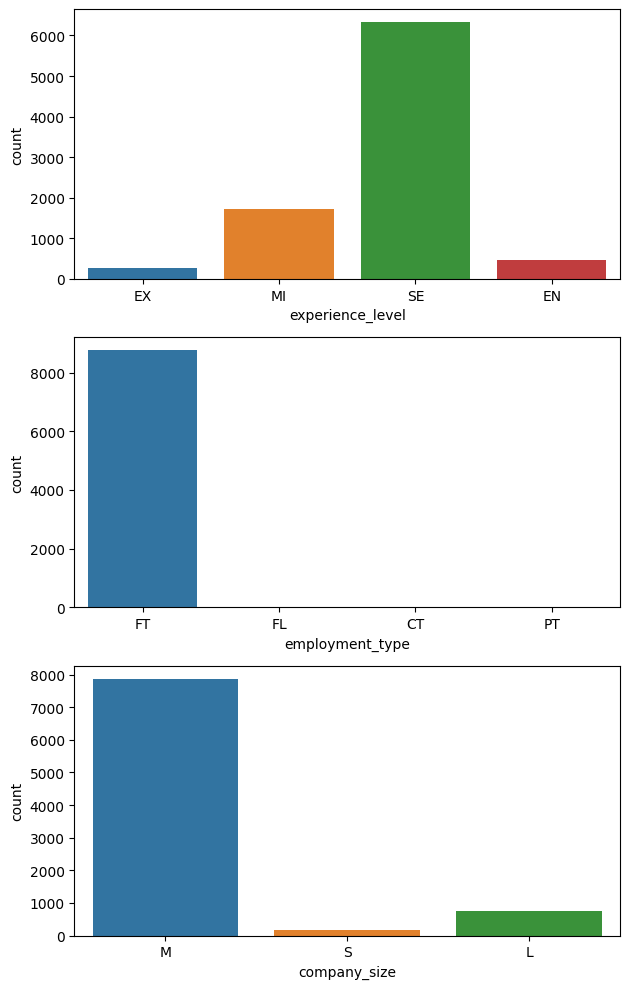

In [7]:
# show count plot based on experience level, employment type, and company size
columns = df.columns
cat = [columns[1], columns[2], columns[10]]
i = 0

fig, axes = plt.subplots(len(cat))

for col in cat:
    sns.countplot(df, ax=axes[i], x=col)
    i += 1

fig.set_figheight(10)
fig.tight_layout()
plt.show()

In [8]:
df.employment_type.value_counts()

FT    8762
CT      18
PT      13
FL      12
Name: employment_type, dtype: int64

Based on employment type, almost all jobs in this dataset are categorized as full-time (FT); while contract, part-time, and full-time jobs only occurs less than 20 times each. The overwhelming discrepancy and the lacking amount of data samples on the three minority categories should be considered when analyzing this dataset. To simplify analysis and also to avoid biases, **only full-time jobs will be analyzed further**.

Based on experience level and company size, there is one category on both variables that is significantly larger in their number of samples than the rest of categories, but other categories still have a decent amount of samples.

In [9]:
# filter dataset to only contain full time employees
df2 = df[df['employment_type'] == 'FT']

## Job Salaries

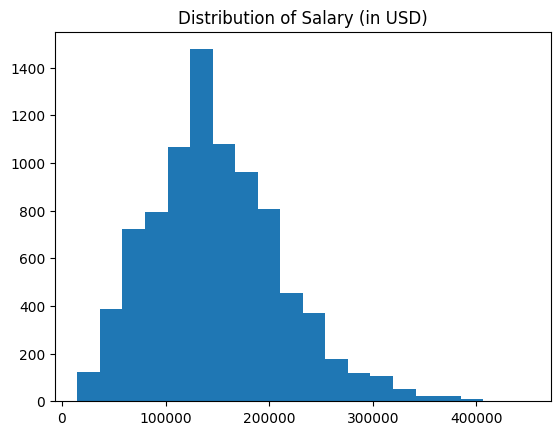

In [10]:
# salary distribution
plt.hist(df2.salary_in_usd, bins=20)

plt.title('Distribution of Salary (in USD)')
plt.show()

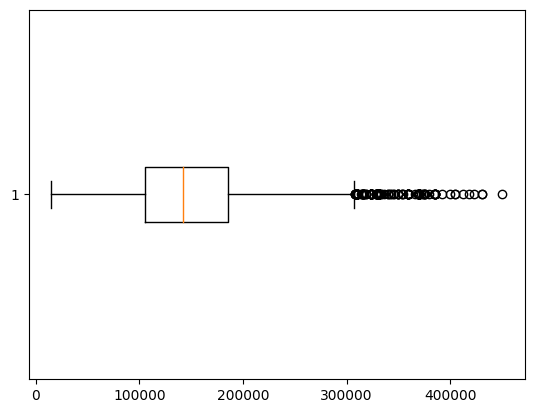

In [11]:
plt.boxplot(df2.salary_in_usd, vert=False)
plt.show()

Based on the distribution, most salaries in the dataset falls between 100K to 200K USD, while there are only a small amount of outliers with salaries above 300K. This is range of salaries combined from all job titles and experience levels. A more detailed analysis on salaries based on job titles and experience levels can be seen further down below, after the analysis on job titles and experience levels.

## Job Titles

In [12]:
# count the number of unique job titles
print('Job Titles:', df.job_title.unique())
print('\n Number of Unique Job Titles:', df2.job_title.nunique())

Job Titles: ['Data Science Director' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Specialist' 'Data Scientist'
 'ML Engineer' 'Data Engineer' 'Data Analyst' 'Data Architect'
 'Data Product Manager' 'Analytics Engineer'
 'Business Intelligence Consultant' 'BI Data Analyst' 'Research Scientist'
 'Data Integration Engineer' 'AI Engineer' 'Applied Scientist'
 'Machine Learning Scientist' 'BI Developer'
 'Business Intelligence Manager' 'Data Integration Specialist'
 'Data Science Practitioner' 'Research Engineer'
 'Business Intelligence Analyst' 'Business Intelligence Developer'
 'AI Research Engineer' 'Data Science Consultant' 'Data Lead'
 'Head of Data' 'Data Management Specialist' 'AI Developer' 'Data Manager'
 'AI Architect' 'MLOps Engineer' 'Data Science Manager' 'Data Strategist'
 'Business Intelligence Specialist'
 'Machine Learning Infrastructure Engineer' 'Research Analyst'
 'Data Quality Engineer' 'Director of Data Science'
 'Business Data Analyst' 'Data Qua

We should take note that some job titles are actually similar, if not completely the same title, as another. For example, ML Engineer is basically the same as Machine Learning Engineer, while BI Analyst is also the same as Business Intelligence Analyst. To simplify things, we shall combine similar job titles as one.

In [25]:
df2.loc[df2.job_title=='BI Developer', 'job_title'] = 'Business Intelligence Developer'
df2.loc[df2.job_title=='BI Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='BI Data Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='BI Data Analyst', 'job_title'] = 'Business Intelligence Analyst'
df2.loc[df2.job_title=='ML Engineer', 'job_title'] = 'Machine Learning Engineer'

In [26]:
# count the number of unique job titles after combining similar titles
print('Job Titles:', df.job_title.unique())
print('\n Number of Unique Job Titles:', df2.job_title.nunique())

Job Titles: ['Data Science Director' 'Business Intelligence Engineer'
 'Machine Learning Engineer' 'Data Specialist' 'Data Scientist'
 'ML Engineer' 'Data Engineer' 'Data Analyst' 'Data Architect'
 'Data Product Manager' 'Analytics Engineer'
 'Business Intelligence Consultant' 'BI Data Analyst' 'Research Scientist'
 'Data Integration Engineer' 'AI Engineer' 'Applied Scientist'
 'Machine Learning Scientist' 'BI Developer'
 'Business Intelligence Manager' 'Data Integration Specialist'
 'Data Science Practitioner' 'Research Engineer'
 'Business Intelligence Analyst' 'Business Intelligence Developer'
 'AI Research Engineer' 'Data Science Consultant' 'Data Lead'
 'Head of Data' 'Data Management Specialist' 'AI Developer' 'Data Manager'
 'AI Architect' 'MLOps Engineer' 'Data Science Manager' 'Data Strategist'
 'Business Intelligence Specialist'
 'Machine Learning Infrastructure Engineer' 'Research Analyst'
 'Data Quality Engineer' 'Director of Data Science'
 'Business Data Analyst' 'Data Qua

In [27]:
# list of job titles with more than 50 entries
job_title_count = df2.job_title.value_counts()
job_title_count[job_title_count.values > 50]

Data Engineer                      2059
Data Scientist                     1848
Data Analyst                       1317
Machine Learning Engineer          1001
Applied Scientist                   258
Research Scientist                  245
Analytics Engineer                  241
Data Architect                      199
Business Intelligence Engineer      134
Research Engineer                   133
Data Manager                        130
Data Science Manager                 92
Business Intelligence Analyst        88
Machine Learning Scientist           70
Business Intelligence Developer      67
Name: job_title, dtype: int64

In [28]:
# count of job titles with more than 50 entries
print('Number of unique job titles with more than 50 entries:', job_title_count[job_title_count.values > 50].count())

Number of unique job titles with more than 50 entries: 15


While there are many job titles in this dataset, some titles might be similar to the other in practice and only differing in its name. Many job titles have less than 50 entries, while only 15 titles occured more than 50 times in this dataset. The most common job titles are **Data Engineer**, **Data Scientist**, and **Data Analyst**.

In [29]:
# filtered dataframe containing only the titles that occurs more than 50 times
df3 = df2[df2['job_title'].isin(list(job_title_count[job_title_count.values > 50].index))]
df3

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
2,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
3,2023,MI,FT,Business Intelligence Engineer,35000,GBP,43064,GB,0,GB,M,onsite
4,2023,SE,FT,Machine Learning Engineer,245700,USD,245700,US,0,US,M,onsite
5,2023,SE,FT,Machine Learning Engineer,132300,USD,132300,US,0,US,M,onsite
8,2023,SE,FT,Machine Learning Engineer,212000,USD,212000,US,0,US,M,onsite
...,...,...,...,...,...,...,...,...,...,...,...,...
8796,2021,MI,FT,Data Scientist,160000,SGD,119059,SG,100,IL,M,remote
8798,2021,MI,FT,Data Engineer,24000,EUR,28369,MT,50,MT,L,hybrid
8800,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L,remote
8802,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S,remote


After filtering out jobs that occur less than 50 times in this dataset, we still retain 7882 data entries. Around one thousand entries has been removed compared to the original, but any analysis related to job title should now perform better.

## Experience Levels per Job Title

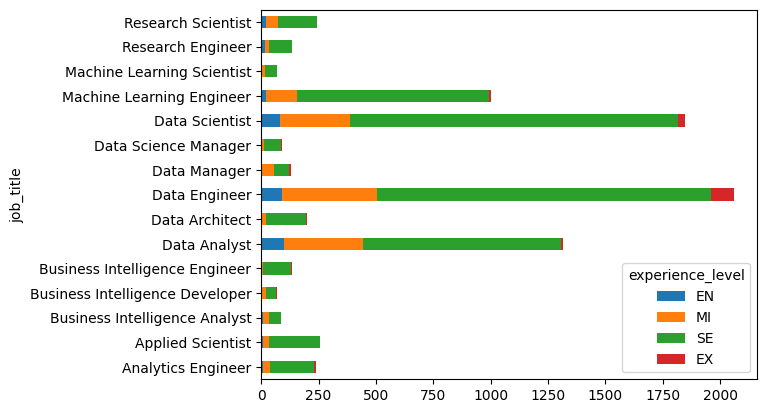

In [30]:
df3.groupby(by=['job_title', 'experience_level']).size().unstack().reindex(['EN','MI','SE','EX'], axis=1).plot(kind='barh', stacked=True)
plt.show()

In all selected job titles, most respondent are Senior-level, composing more than 50% of all experience level count. Mid-level are also quite common across the board, while entry level are mostly on Data Analyst, Engineer, or Scientist role.

# Salaries per Job Title & Experience Levels

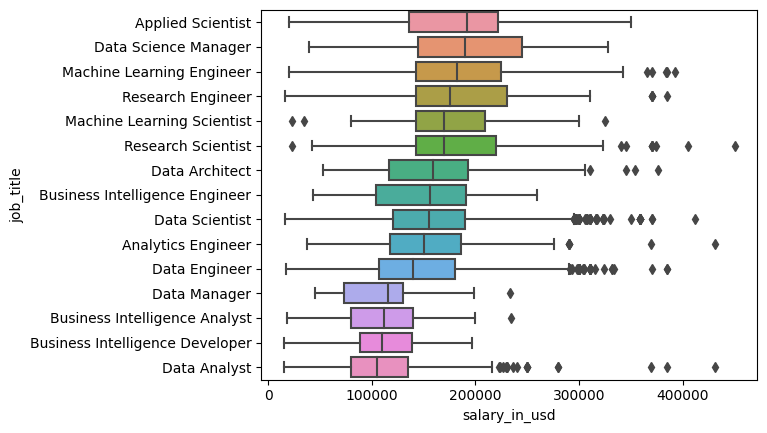

In [33]:
# order titles by median value
grouped = df3.loc[:,['job_title', 'salary_in_usd']] \
    .groupby(['job_title']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# create boxplot of salaries in usd for each selected job titles
sns.boxplot(data=df3, x='salary_in_usd', y='job_title', order=grouped.index)
plt.show()

In general, Data Analyst, BI Developer, BI Analyst, and Data Manager are the lowest paying job title among the selected job titles, with a significant portion of respondents on those groups having a salary less than 100k. Other job titles earning similar amounts to each other, typically ranging from 100k to 200k USD.

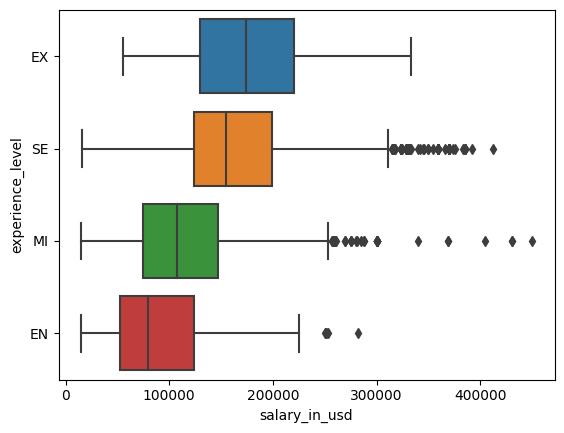

In [39]:
# order experience level by median value
grouped2 = df3.loc[:,['experience_level', 'salary_in_usd']] \
    .groupby(['experience_level']) \
    .median() \
    .sort_values(by='salary_in_usd', ascending=False)

# boxplot for salary in usd based on experience level
sns.boxplot(data=df3, x='salary_in_usd', y='experience_level', order=grouped2.index)
plt.show()

Based on experience level, on average a lower experience level earns less than the higher experience levels, but it is not quite clear-cut on whether the difference is significant or not based only on the graph above - especially since the highest salary among the dataset is earned by a mid-level, and that some executive-level still earns less than the average entry level, even when ignoring the outliers (which is shown by the dots on the graph above).

To check whether or not the difference of experience level is actually significant to salary earned, an analysis of variance (ANOVA) will be performed.

In [21]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('salary_in_usd ~ experience_level', data=df3).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
experience_level,4.051451e+12,3.0,403.235833,1.105468e-243
Residual,2.638434e+13,7878.0,NaN,NaN


In [22]:
df3[df3['experience_level']=='EN']

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,remote_cat
45,2023,EN,FT,Business Intelligence Analyst,25000,USD,25000,UA,100,NL,M,remote
120,2023,EN,FT,Data Analyst,109900,USD,109900,US,0,US,M,onsite
121,2023,EN,FT,Data Analyst,61200,USD,61200,US,0,US,M,onsite
288,2023,EN,FT,Data Scientist,133000,USD,133000,US,0,US,M,onsite
289,2023,EN,FT,Data Scientist,58400,USD,58400,US,0,US,M,onsite
...,...,...,...,...,...,...,...,...,...,...,...,...
8720,2020,EN,FT,Data Scientist,35000,EUR,39916,FR,0,FR,M,onsite
8725,2021,EN,FT,Machine Learning Engineer,81000,USD,81000,US,50,US,S,hybrid
8738,2020,EN,FT,Data Engineer,4450000,JPY,41689,JP,100,JP,S,remote
8760,2020,EN,FT,Data Scientist,55000,EUR,62726,DE,50,DE,S,hybrid


In [23]:
from scipy.stats import f_oneway

# Conduct the one-way ANOVA
f_oneway(df3[df3['experience_level']=='EN']['salary_in_usd'], df3[df3['experience_level']=='MI']['salary_in_usd'], df3[df3['experience_level']=='SE']['salary_in_usd'], df3[df3['experience_level']=='EX']['salary_in_usd'])

F_onewayResult(statistic=403.23583279762, pvalue=1.105468290280747e-243)

In [24]:
# check which group is significantly different using tukey HSD
res = stat()
res.tukey_hsd(df=df3, res_var='salary_in_usd', xfac_var='experience_level', anova_model='salary_in_usd ~ experience_level')
res.tukey_summary

/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]
/usr/local/lib/python3.10/dist-packages/bioinfokit/analys.py:421: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to 

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,MI,SE,46532.251005,42197.682506,50866.819503,39.010678,0.001000
1,MI,EN,25754.738579,17069.647732,34439.829425,10.776013,0.001000
2,MI,EX,60074.850373,48530.824688,71618.876058,18.910836,0.001000
3,SE,EN,72286.989583,64274.834559,80299.144608,32.785824,0.001000
4,SE,EX,13542.599368,2495.954894,24589.243842,4.454992,0.008895
5,EN,EX,85829.588951,72462.813982,99196.363921,23.333813,0.001000


Based on the p-value of ANOVA and the p-value of Tukey's HSD on all group pairs (lower than 0.01), we can conclude that each group of experience level is significantly different in their average salary received. The increase of salary goes in line with the increase in experience level, although some respondents with the lowest experience level (entry-level) still obtained a higher salary than the average salary of the highest experience level (executive-level).